<a href="https://colab.research.google.com/github/hailuu684/Convolution-net/blob/main/slightly_changed_HungarianLoss%2BBCELoss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
print(np.__version__)
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import csv

!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, Concatenate, Input, Lambda

1.19.5
     |████████████████████████████████| 1.1 MB 24.4 MB/s 


# Preprocess Hungarian Loss

In [ ]:
def replacenan(t):
    return tf.where(tf.math.is_nan(t), x = tf.zeros_like(t), y = t)

def replace_nan_by_10_square_10(t):
    return tf.where(tf.math.is_nan(t), x = 10**10, y = t)

def replace_10_square_10_by_zero(t):
    return tf.where(tf.math.equal(t, 10**10), x = 0.0 + 1e-10, y = t)

def replace_zero_by_two(t):
    return tf.where(tf.math.equal(t, 0), x = 2.0, y = t)

def replace_two_by_zero(t):
    return tf.where(tf.math.equal(t, 2), x = 0.0 + 1e-10, y = t)

def remove_zero(t):
    intermediate_tensor = t
    # intermediate_tensor = tf.cast(intermediate_tensor,tf.double)
    batch = t.shape[0]
    zero_vector = tf.zeros(shape=t.shape, dtype=tf.double)
    bool_mask = tf.not_equal(intermediate_tensor, zero_vector)
    omit_zeros = tf.boolean_mask(intermediate_tensor, bool_mask)
    # tf.print('omit zero',omit_zeros)

    non_zero_dimension = int(len(omit_zeros) / batch)


    omit_zeros = tf.reshape(omit_zeros,shape=(batch,non_zero_dimension))
    return omit_zeros

# Test data hungarian loss

In [ ]:
y_true_test_h_l = tf.random.uniform(shape=(16,28,),dtype=tf.double)
y_pred_test_h_l = tf.random.uniform(shape=(16,28,),dtype=tf.double)

y_true_test_h_l = np.array(y_true_test_h_l)
y_pred_test_h_l = np.array(y_pred_test_h_l)

y_true_test_h_l[:,8:] = np.nan
# y_pred_test_h_l[:,8:] = np.nan

y_true_test_h_l[:,11] = 0
y_true_test_h_l[:,15] = 0
y_true_test_h_l[:,19] = 0
y_true_test_h_l[:,23] = 0
y_true_test_h_l[:,27] = 0

y_pred_test_h_l[:,11] = 0
y_pred_test_h_l[:,15] = 0
y_pred_test_h_l[:,19] = 0
y_pred_test_h_l[:,23] = 0
y_pred_test_h_l[:,27] = 0

# Test 0 like 0 in relative coordinate
# y_true_test_h_l[:,2][0] = 0.5
# y_true_test_h_l[:,0][0] = 0



for i in range(len(y_true_test_h_l[:,3])):
    y_true_test_h_l[:,2][i] = np.random.choice([0,1],p=[0.5, 0.5])
    y_pred_test_h_l[:,2][i] = np.random.choice([0,1],p=[0.5, 0.5])

    y_true_test_h_l[:,6][i] = np.random.choice([0,1],p=[0.5, 0.5])
    y_pred_test_h_l[:,6][i] = np.random.choice([0,1],p=[0.5, 0.5])

    # confident values
    y_true_test_h_l[:,3][i] = 1.0
    y_pred_test_h_l[:,3][i] = 1.0
    y_true_test_h_l[:,7][i] = 1.0
    y_pred_test_h_l[:,7][i] = 1.0

y_true_test_h_l[1,8] = 2.342432
y_true_test_h_l[1,9] = 1.534534
y_true_test_h_l[1,10] = 0
y_true_test_h_l[1,11] = 1.0

y_pred_test_h_l[1,8] = 1.3432
y_pred_test_h_l[1,9] = 1.7453
y_pred_test_h_l[1,10] = 0.2
y_pred_test_h_l[1,11] = 0.9

y_true_test_h_l = tf.convert_to_tensor(y_true_test_h_l)
y_pred_test_h_l = tf.convert_to_tensor(y_pred_test_h_l)

In [ ]:
tf.reshape(y_pred_test_h_l,shape=(16,7,4))

In [ ]:
y = tf.constant([1,2], dtype = tf.float32)
tf.math.reduce_euclidean_norm([[1,2,3]])

In [ ]:
y_true_test_h_bug = tf.random.uniform(shape=(64,28,),dtype=tf.double)
y_pred_test_h_bug = tf.random.uniform(shape=(64,28,),dtype=tf.double)
hungarian_loss(y_true_test_h_bug,y_pred_test_h_bug)

In [ ]:
hungarian_loss_test(y_true_test_h_l,y_pred_test_h_l)

# Hungarian loss

In [ ]:
def hungarian_loss(y_true, y_pred): # -----> worked with non-nan values, the trick here is you should not use for loop 
    from scipy.optimize import linear_sum_assignment

    batch_size = tf.shape(y_true)[0]
    y_h = int(y_true.shape[1]//4)

    y_true_reshape = tf.reshape(y_true,shape=(batch_size,y_h,4))
    y_pred_reshape = tf.reshape(y_pred,shape=(batch_size,y_h,4))

    # Take only 2 first dimension
    y_true_ = y_true_reshape[:,:,:2] # shape = (16,7,2) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_ = y_pred_reshape[:,:,:2]
    # print(y_true_)

    # tf.print('y_true',y_true_)
    # tf.print('y_pred',y_pred_)

    # if change nan --> 10^10
    y_true_ = replace_nan_by_10_square_10(y_true_) # shape = (16,7,2)
    y_pred_ = replace_nan_by_10_square_10(y_pred_)

    y_true_ = tf.cast(y_true_,dtype=tf.double)
    y_pred_ = tf.cast(y_pred_,dtype=tf.double)

    store_element = [tf.math.reduce_euclidean_norm(tf.constant((y_true_[:,i,:2] - y_pred_[:,j,:2]),dtype=tf.double),axis=-1) for i in range(y_true_.shape[1]) for j in range(y_true_.shape[1])]
    store_cost = tf.convert_to_tensor(store_element)
    store_cost = tf.transpose(store_cost, perm=[1,0])
    

    cost_batch, cost_H_W = store_cost.shape
    cost_reshape = tf.reshape(store_cost,shape=(cost_batch,int(np.sqrt(cost_H_W)), int(np.sqrt(cost_H_W)) ))
    # print('cost = \n',cost_reshape) # shape = (16,7,7)

    final_cost = []
    pair_row_col = []


    for i in range(cost_reshape.shape[0]):
        row_ind, col_ind = linear_sum_assignment(cost_reshape[i,:]) # find the row_ind and col_ind for each batch
        chosen_elements = zip(row_ind.tolist(), col_ind.tolist())
        # print(row_ind,col_ind)
        for row,col in zip(row_ind,col_ind): 
            if cost_reshape[i,row,col] < 10**10:
                final_cost.append(cost_reshape[i,row,col])  
                # chosen_elements = zip(row_ind.tolist(), col_ind.tolist())  
                # pair_row_col.append(chosen_elements)    
        pair_row_col.append(chosen_elements)


    
    final_cost = tf.convert_to_tensor(final_cost) 
    # print('final cost shape',final_cost.shape) # shape = ( 112,) = (16,7)
    

    cost = tf.cast(final_cost,dtype=tf.float32)
    #-----------------------------
    #--------Hungarian loss-------
    #-----------------------------

    # final_cost = tf.reduce_mean(cost,axis=-1) # shape = (batch,)
    final_cost = tf.reduce_mean(final_cost) # shape = ()
    # tf.print('\nDone hungarian loss part')
    #----------------
    #---class loss--- note that 16 is the batch
    #----------------
    # print(y_true_reshape)

    # Get the class
    y_true_cls = y_true_reshape[:,:,2] # shape = (16,7,1) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_cls = tf.sigmoid(y_pred_reshape[:,:,2])
    
    # Confident scores
    y_true_conf = y_true_reshape[:,:,3] # shape = (16,7,1) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_conf = tf.sigmoid(y_pred_reshape[:,:,3])

    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    
    y_true_cls_tf = []
    y_pred_cls_tf = []
    cls_loss = []
    store_confident_loss = []
    for batch_pair in pair_row_col:
        for row,col in batch_pair:
            ## y_true_cls[row,:] = [ 1 0 10e+10 10e+10 10e+10 10e+10 10e+10]
            # len_cls_label_true = len(np.array(y_true_cls[row,:]))
            # len_cls_label_pred = len(np.array(y_pred_cls[col,:]))

            if row < len(y_pred_cls) and col < len(y_true_cls):
                # Number of object in one frame
                num_object_true = np.count_nonzero(~np.isnan(np.array(y_true_cls[col,:])))
                # num_object_pred = np.count_nonzero(~np.isnan(np.array(y_pred_cls[col,:])))

                # Calculate loss
                # print('y_true',y_true_cls[row,:num_object_true])
                # print('y_pred',y_pred_cls[col,:num_object_true])
            
                if len(y_true_cls[col,:num_object_true]) == len(y_pred_cls[row,:num_object_true]):
                    y_true_cls_tf.append(y_true_cls[col,:num_object_true])
                    y_pred_cls_tf.append(y_pred_cls[row,:num_object_true])
                    cls_bce_loss = bce(y_true_cls[col,:num_object_true], y_pred_cls[row,:num_object_true])
                    cls_loss.append(cls_bce_loss)
                
                # print('y_true',y_true_conf[row,:])
                # print('y_pred',y_pred_conf[col,:])
                confident_loss = bce(y_true_conf[col,:], y_pred_conf[row,:])
                store_confident_loss.append(confident_loss)
            else:
                tf.print('indices from hungarian algorithm is larger than the object')
                tf.print('col = \n', col)
                tf.print('row = \n', row)
                tf.print('y true = \n', y_true_cls)
                tf.print('y pred = \n',y_pred_cls)

    reduce_mean_cls_loss = tf.reduce_mean(cls_loss)
    # tf.print('\nDone class loss part')
    #------------------------
    #-----Confident Loss-----
    #------------------------
    reduce_confident_loss = tf.reduce_mean(store_confident_loss)
    # print('confident loss', store_confident_loss)

    #----------------------------
    #------ SUM OF LOSSES--------
    #----------------------------
    regression_loss = final_cost

    # Training
    regression_loss = tf.cast(regression_loss,dtype=tf.float32)

    # Testing
    # regression_loss = tf.cast(regression_loss,dtype=tf.double)

    tf.print('\nreduce_confident_loss = ', reduce_confident_loss)
    tf.print('\nreduce_mean_cls_loss = ', reduce_mean_cls_loss)
    tf.print('\nregression loss = ', regression_loss)
    sum_loss = reduce_mean_cls_loss + regression_loss + reduce_confident_loss
    return sum_loss

In [ ]:
hungarian_loss(y_true_test_h_l,y_pred_test_h_l)

y_true [[[0.9594437655188186 0.18418625623256712]
  [0.60027210290549649 0.67695129731242254]
  [nan nan]
  ...
  [nan nan]
  [nan nan]
  [nan nan]]

 [[0.14659053565153779 0.23023923300875704]
  [0.28673074621247019 0.080505630743321177]
  [2.342432 1.534534]
  ...
  [nan nan]
  [nan nan]
  [nan nan]]

 [[0.73578588625084151 0.45678510045648579]
  [0.89984797721977161 0.30570071429675982]
  [nan nan]
  ...
  [nan nan]
  [nan nan]
  [nan nan]]

 ...

 [[0.39633733433213214 0.74309534071096728]
  [0.73802075602145867 0.6307451293673505]
  [nan nan]
  ...
  [nan nan]
  [nan nan]
  [nan nan]]

 [[0.56442038784854054 0.73943245169425231]
  [0.827929785824987 0.42285523635337974]
  [nan nan]
  ...
  [nan nan]
  [nan nan]
  [nan nan]]

 [[0.347224107257849 0.19775412965213168]
  [0.44146679885271212 0.82631294618117779]
  [nan nan]
  ...
  [nan nan]
  [nan nan]
  [nan nan]]]
y_pred [[[0.10841243929717836 0.45805752304129888]
  [0.45480098276143677 0.044750702604267056]
  [0.96086120286961907

<tf.Tensor: shape=(), dtype=float64, numpy=1.8222597873888793>

# slightly change hungarian loss

In [ ]:
def hungarian_loss_test(y_true, y_pred): # -----> worked with non-nan values, the trick here is you should not use for loop 
    from scipy.optimize import linear_sum_assignment

    batch_size = tf.shape(y_true)[0]

    y_h = int(y_true.shape[1]//4)
    y_true_reshape = tf.reshape(y_true,shape=(batch_size,y_h,4))
    y_pred_reshape = tf.reshape(y_pred,shape=(batch_size,y_h,4))

    # Take only 2 first dimensions
    y_true_ = y_true_reshape[:,:,:2] # shape = (16,7,2) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_ = y_pred_reshape[:,:,:2]

    # tf.print('y_true \n',y_true_)
    # tf.print('y_pred \n',y_pred)

    y_true_ = tf.cast(y_true_,dtype=tf.float32)
    y_pred_ = tf.cast(y_pred_,dtype=tf.float32)

    store_element = [tf.math.reduce_euclidean_norm(tf.constant((y_true_[:,i,:2] - y_pred_[:,j,:2]),dtype=tf.float32),axis=-1) for i in range(y_true_.shape[1]) for j in range(y_true_.shape[1])]
    store_cost = tf.convert_to_tensor(store_element)
    store_cost = tf.transpose(store_cost, perm=[1,0])
    

    cost_batch, cost_H_W = store_cost.shape
    cost_reshape = tf.reshape(store_cost,shape=(cost_batch,int(np.sqrt(cost_H_W)), int(np.sqrt(cost_H_W)) )) # ( batch, 7,7)
     # shape = (16,7,7)
    cost_reshape = replace_nan_by_10_square_10(cost_reshape)
    # tf.print('cost = \n',cost_reshape)
    # tf.print('cost shape = ', cost_reshape.shape)
    final_cost = []
    pair_row_col = []


    for i in range(cost_reshape.shape[0]):
        row_ind, col_ind = linear_sum_assignment(cost_reshape[i,:]) # find the row_ind and col_ind for each batch
        chosen_elements = zip(row_ind.tolist(), col_ind.tolist())
        # print(row_ind,col_ind)
        for row,col in zip(row_ind,col_ind): 
            if cost_reshape[i,row,col] < 10**10:
                final_cost.append(cost_reshape[i,row,col])  
                # chosen_elements = zip(row_ind.tolist(), col_ind.tolist())  
                # pair_row_col.append(chosen_elements)    
        pair_row_col.append(chosen_elements)


    
    final_cost = tf.convert_to_tensor(final_cost) 
    # print('final cost shape',final_cost.shape) # shape = ( 112,) = (16,7)
    

    cost = tf.cast(final_cost,dtype=tf.float32)
    #-----------------------------
    #--------Hungarian loss-------
    #-----------------------------

    # final_cost = tf.reduce_mean(cost,axis=-1) # shape = (batch,)
    final_cost = tf.reduce_mean(final_cost) # shape = ()
    # tf.print('\nDone hungarian loss part')
    #----------------
    #---class loss--- note that 16 is the batch
    #----------------
    # print(y_true_reshape)

    y_true_cls = y_true_reshape[:,:,2] # shape = (16,7,1) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_cls = tf.sigmoid(y_pred_reshape[:,:,2])
    
    # Confident scores
    y_true_conf = y_true_reshape[:,:,3] # shape = (16,7,1) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_conf = tf.sigmoid(y_pred_reshape[:,:,3])

    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    
    y_true_cls_tf = []
    y_pred_cls_tf = []
    cls_loss = []
    store_confident_loss = []
    for batch_pair in pair_row_col:
        for row,col in batch_pair:

            if row < len(y_pred_cls) and col < len(y_true_cls):
                # Number of object in one frame
                num_object_true = np.count_nonzero(~np.isnan(np.array(y_true_cls[col,:])))
                # num_object_pred = np.count_nonzero(~np.isnan(np.array(y_pred_cls[col,:])))

            
                if len(y_true_cls[col,:num_object_true]) == len(y_pred_cls[row,:num_object_true]):
                    y_true_cls_tf.append(y_true_cls[col,:num_object_true])
                    y_pred_cls_tf.append(y_pred_cls[row,:num_object_true])
                    cls_bce_loss = bce(y_true_cls[col,:num_object_true], y_pred_cls[row,:num_object_true])
                    cls_loss.append(cls_bce_loss)

                    confident_loss = bce(y_true_conf[col,:], y_pred_conf[row,:])
                    store_confident_loss.append(confident_loss)
            else:
                tf.print('indices from hungarian algorithm is larger than the object')
                tf.print('col = \n', col)
                tf.print('row = \n', row)
                tf.print('y true = \n', y_true_cls)
                tf.print('y pred = \n',y_pred_cls)

    reduce_mean_cls_loss = tf.reduce_mean(cls_loss)
    # tf.print('\nDone class loss part')
    #------------------------
    #-----Confident Loss-----
    #------------------------
    reduce_confident_loss = tf.reduce_mean(store_confident_loss)
    # print('confident loss', store_confident_loss)

    #----------------------------
    #------ SUM OF LOSSES--------
    #----------------------------
    regression_loss = final_cost

    # Training
    regression_loss = tf.cast(regression_loss,dtype=tf.float32)

    # Testing
    # regression_loss = tf.cast(regression_loss,dtype=tf.double)

    # tf.print('\nreduce_confident_loss = ', reduce_confident_loss)
    # tf.print('\nreduce_mean_cls_loss = ', reduce_mean_cls_loss)
    # tf.print('\nregression loss = ', regression_loss)
    sum_loss = reduce_mean_cls_loss + regression_loss + reduce_confident_loss
    return sum_loss

# Use with model.fit() 
def hungarian_loss_fit_test(y_true, y_pred):
    loss = tf.py_function(func=hungarian_loss_test, inp=[y_true,y_pred], Tout=tf.float32,)
    loss_tensor = tf.convert_to_tensor(loss)
    # print('hungarian loss shape',cost_tensor.shape)

    return loss_tensor

In [ ]:
hungarian_loss_test(y_true_test_h_l,y_pred_test_h_l)

cost = 
 [[[0.193659514 0.148534104 0.440788865 ... 0.882218242 0.201700673 0.849517]
  [0.476395965 0.487233788 0.380835712 ... 0.277627259 0.528800964 0.230658546]
  [1e+10 1e+10 1e+10 ... 1e+10 1e+10 1e+10]
  ...
  [1e+10 1e+10 1e+10 ... 1e+10 1e+10 1e+10]
  [1e+10 1e+10 1e+10 ... 1e+10 1e+10 1e+10]
  [1e+10 1e+10 1e+10 ... 1e+10 1e+10 1e+10]]

 [[0.0326961689 0.371385038 1.04262865 ... 0.577944219 0.201805219 0.70638907]
  [0.667315185 0.743829489 1.42213762 ... 0.27326411 0.498248219 0.106565461]
  [1.58089912 1.82260823 1.02121842 ... 2.18821263 1.70456493 2.21871328]
  ...
  [1e+10 1e+10 1e+10 ... 1e+10 1e+10 1e+10]
  [1e+10 1e+10 1e+10 ... 1e+10 1e+10 1e+10]
  [1e+10 1e+10 1e+10 ... 1e+10 1e+10 1e+10]]

 [[0.359569937 0.36499396 0.748291433 ... 0.552292347 0.5146662 0.639129341]
  [0.284199983 0.420850813 0.817118049 ... 0.710601091 0.157643139 0.00395428482]
  [1e+10 1e+10 1e+10 ... 1e+10 1e+10 1e+10]
  ...
  [1e+10 1e+10 1e+10 ... 1e+10 1e+10 1e+10]
  [1e+10 1e+10 1e+10 ... 1

<tf.Tensor: shape=(), dtype=float64, numpy=1.6660322360694408>

In [ ]:
tf.reshape(y_true_test_h_l,shape=(16,7,4))

In [ ]:
cost_test = np.array([[4, 1, np.inf], [np.inf, 2, 5], [0.5, 2, 0.25]])
from scipy.optimize import linear_sum_assignment
row_ind, col_ind = linear_sum_assignment(cost_test)

In [ ]:
row_ind, col_ind

In [ ]:
cost_test[row_ind, col_ind].sum()

In [ ]:
test_cost_matrix_true = tf.random.uniform(shape=(2,2))
test_cost_matrix_pred = tf.random.uniform(shape=(2,2))
store_element = [tf.square(test_cost_matrix_true[:,i] - test_cost_matrix_pred[:,j]) for i in range(test_cost_matrix_true.shape[1]) for j in range(test_cost_matrix_pred.shape[1])]

In [ ]:
hungarian_loss(y_true_test_h_l,y_pred_test_h_l)

# Test loss

In [ ]:
import tensorflow.keras.backend as K
def rmsle_K(y_true, y_pred):
    batch_size = tf.shape(y_true)[0]
    y_h = int(y_true.shape[1]//4)

    y_true_reshape = tf.reshape(y_true,shape=(batch_size,y_h,4))
    y_pred_reshape = tf.reshape(y_pred,shape=(batch_size,y_h,4))

    # Take only 2 first dimension
    y_true_ = y_true_reshape[:,:,:2] # shape = (16,7,2) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_ = y_pred_reshape[:,:,:2]

    return K.sqrt(tf.experimental.numpy.nanmean(K.square(tf.math.log1p(y_true_) - tf.math.log1p(y_pred_))))

def rmsle_K_fit_test(y_true, y_pred):
    loss = tf.py_function(func=rmsle_K, inp=[y_true,y_pred], Tout=tf.float32,)
    loss_tensor = tf.convert_to_tensor(loss)
    return loss_tensor

In [ ]:
rmsle_K(y_true_test_h_l,y_pred_test_h_l)

<tf.Tensor: shape=(), dtype=float64, numpy=0.25896492599772303>

# Custom metrics

In [ ]:
import tensorflow.keras.backend as K

def custom_mse(y_true, y_pred):
    y_true = tf.cast(y_true,dtype=tf.float32)
    y_pred = tf.cast(y_pred,dtype=tf.float32)
    loss = K.square(y_pred - y_true)  # (batch_size, 2)
    loss = tf.experimental.numpy.nanmean(loss,axis=-1)
    loss = tf.reduce_mean(loss)
    return loss

In [ ]:
class custom_MSE(tf.keras.metrics.Metric):

  def __init__(self, name='custom_mse', **kwargs):
    super(custom_MSE, self).__init__(name=name, **kwargs)
    self.true_positives = self.add_weight(name='tp', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)
    
    batch_size = tf.shape(y_true)[0]
    y_h = int(y_true.shape[1]//4)
    
    y_true_reshape = tf.reshape(y_true,shape=(batch_size,y_h,4))
    y_pred_reshape = tf.reshape(y_pred,shape=(batch_size,y_h,4))
    y_true_ = y_true_reshape[:,:,:2] # shape = (16,7,2) for example y_true_test_h_l[:,8:] = np.nan
    y_pred_ = y_pred_reshape[:,:,:2]
    
    y_true_ = tf.cast(y_true_, tf.float32)
    y_pred_ = tf.cast(y_pred_, tf.float32)

    # y_true_reg = y_true[:,:2]
    # y_pred_reg = y_pred[:,:2]

    loss = K.square(y_true_ - y_pred_)  
    
    loss = tf.experimental.numpy.nanmean(loss,axis=1)
    # loss = tf.experimental.numpy.nanmean(loss,axis=0)
    # tf.print(loss)
    if sample_weight is not None:
        sample_weight = tf.cast(sample_weight, self.dtype)
        values = tf.multiply(values, sample_weight)
    
    # self.true_positives.assign_add(tf.reduce_mean(loss))
    # tf.print(loss)
    self.true_positives.assign(tf.reduce_mean(loss))

  def result(self):
    return self.true_positives

  def reset_state(self):
    self.true_positives.assign(0)

In [ ]:
test_custom_mse = custom_MSE()
test_custom_mse(y_true_test_h_l,y_pred_test_h_l)

# Preprocess data

In [ ]:
def add_confident_value(label):
    reshape = tf.reshape(label,shape = (7,3))
    store_new_values = np.empty(shape = (7,4))

    for i in range(reshape.shape[0]):
        for j in range(reshape.shape[1]):
            store_new_values[i,j] = reshape[i,j]
        
        if np.isnan(reshape[i,2]):
            # print('in if statement',reshape_test_[i,2])
            store_new_values[i,3] = 0
        else:
            # print('in elif statement',reshape_test_[i,2])
            store_new_values[i,3] = 1
    store_new_values = tf.reshape(store_new_values,shape=(28,))
    return store_new_values

def plot_images(images):
    assert isinstance(images, (list, tuple, np.ndarray))    
    cols = min(6, len(images))
    rows = 1 + (len(images)-1)//cols
    plt.figure(figsize=(3.2*cols, 1.2*rows))
    for n, image in enumerate(images):
        plt.subplot(rows, cols, n+1)
        plt.xticks([], [])
        plt.yticks([], [])
        # plt.xlabel(f'{pred_titles[n]}', size=14, c='blue')
        plt.imshow(image)
    plt.tight_layout()
    plt.show()

def get_dir_name(filename):
    pos1 = filename.rfind('_')
    pos2 = filename.find('.')
    return filename[pos1+1:pos2], filename[0:pos1]

TRAIN_SET_PATH = '/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test'
town_listdir = os.listdir(TRAIN_SET_PATH)
print(town_listdir)

def read_rgb_image(rgb_path):
    image = cv2.imread(rgb_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(200,200))

    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image[0:,:,:]
    image = image/255.0
    return image

def read_depth_image(depth_path):
    depth_img = cv2.imread(depth_path)
    depth_img = cv2.cvtColor(depth_img,cv2.COLOR_BGR2RGB)
    depth_img = cv2.resize(depth_img,(200,200))

    R = depth_img[:, :, 0].astype('float32')
    G = depth_img[:, :, 1].astype('float32')
    B = depth_img[:, :, 2].astype('float32')
    normalized = (R + G * 256 + B * 256 * 256) / (256 * 256 * 256 - 1)
    in_meters = 1000 * normalized
    in_meters[in_meters == 1000] = 0
    in_meters = tf.expand_dims(in_meters,axis=-1)
    return in_meters

def normalize_on_rgb_depth(concat_img):
    # mean = [103.939, 116.779, 123.68, 1]
    channel_avg = np.array([0.485, 0.456, 0.406])
    channel_std = np.array([0.229, 0.224, 0.225])
    # concat_img[:,:,0:3] = (concat_img[:,:,0:3] - channel_avg) / channel_std
    
    
    concat_img_list = concat_img.numpy()
    # print(concat_img_list.shape)
    concat_img_list[:,:,0:3] = (concat_img_list[:,:,0:3] - channel_avg) / channel_std

    concat_img_list[:,:,3][concat_img_list[:,:,3] == 0.0] = 1 # log10(1) = 0 thats what we want, not -inf

    concat_img_list[:,:,3] = np.log10(concat_img_list[:,:,3])
    concat_img_tensor = tf.convert_to_tensor(concat_img_list)
    # concat_img_tensor.astype(np.float32)
    # print(concat_img_tensor)
    concat_img_tensor = tf.cast(concat_img_tensor,tf.float32)
    return concat_img_tensor

['Town04', 'Town01']


# Load data train

In [ ]:
def load_4_side_data_train():
    def fetch_data_pair():
        for i,(town) in enumerate(town_listdir): # use enumerate for debugging to check the loops
            town_path = os.path.join(TRAIN_SET_PATH,town)

            csv_ego_path = os.path.join(town_path,'location.csv')

            csv_agent_path = os.path.join(town_path,'agent_vehicle_information.csv')
            csv_walker_path = os.path.join(town_path,'walkers_information.csv')
            # print(csv_ego_path,csv_agent_path)
            rgb_path = os.path.join(town_path,'rgb_image')

            front_rgb_path = os.path.join(rgb_path,'front_image')
            
            round_1_4 = os.listdir(front_rgb_path)
            round_1_4.sort()

            SET_TRAIN_PATH = [os.path.join(front_rgb_path,round_1_4[i]) for i in range(0,4)]
            
            df = pd.read_csv(csv_ego_path)
            df_agent = pd.read_csv(csv_agent_path)
            df_walker = pd.read_csv(csv_walker_path)

            #------------------------------------------------
            #--------FILL THE MISSING VALUES-----------------
            #------------------------------------------------
            df['relative_x'] = df['relative_x'].fillna(0)
            df['relative_y'] = df['relative_y'].fillna(0)
            df['throttle'] = df['throttle'].fillna(0)
            df['steer'] = df['steer'].fillna(0)

            df_walker['relative_x'] = df_walker['relative_x'].fillna(0)
            df_walker['relative_y'] = df_walker['relative_y'].fillna(0)
            # df_walker['throttle'] = df_walker['throttle'].fillna(0)
            # df_walker['steer'] = df_walker['steer'].fillna(0)
            #-------------------------------------------------

            
            # print('in train',os.path.isfile(csv_agent_path))
            for round in SET_TRAIN_PATH:  
                for subdir,_,name_images in os.walk(round):
                    name_images.sort()
                    # print(subdir)
                    '''
                    subdir: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image/front_image/round1
                    '''

                    # split the directory to get the depth directory
                    '''
                    head1: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image/front_image
                    split_round: round1 -> round 4
                    '''
                    head1, split_round = os.path.split(subdir)
                    
                    '''
                    rgb_img_path_split: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image
                    '''
                    rgb_img_path_split, front_img_split = os.path.split(head1)
                    path_to_town = head1[:97]

                    # print(path_to_town)
                    left_path = 'left_image'
                    right_path = 'right_image'
                    back_path = 'back_image'
                    front_path = 'front_image'


                    path_to_depth = os.path.join(path_to_town,'depth_image')
                    subdir_depth_front = os.path.join(path_to_depth, front_img_split)
                    subdir_depth_round = os.path.join(subdir_depth_front, split_round)
                    # print(subdir_depth_front)

                    for name in name_images:
                        # print(name)
                        path_to_rgb_front_img = os.path.join(subdir,name)
                        # print(subdir)

                        # path to rgb left image
                        path_to_rgb_left = os.path.join(rgb_img_path_split,left_path)
                        path_to_rgb_left_img = os.path.join(path_to_rgb_left,split_round)
                        path_to_rgb_left_img = os.path.join(path_to_rgb_left_img,name)
                        # print(path_to_rgb_left_img)
                        # print(os.path.isfile(path_to_rgb_left_img))
                        # print(path_to_rgb_left_img)

                        # path to rgb right image
                        path_to_rgb_right = os.path.join(rgb_img_path_split,right_path)
                        path_to_rgb_right_img = os.path.join(path_to_rgb_right,split_round)
                        path_to_rgb_right_img = os.path.join(path_to_rgb_right_img,name)
                        # print(os.path.isfile(path_to_rgb_right_img))

                        # path to rgb back image
                        path_to_rgb_back = os.path.join(rgb_img_path_split,back_path)
                        path_to_rgb_back_img = os.path.join(path_to_rgb_back,split_round)
                        path_to_rgb_back_img = os.path.join(path_to_rgb_back_img,name)
                        # print(os.path.isfile(path_to_rgb_back_img))




                        # --------------------Split the path to get the path depth---------------------------

                       
                        path_to_depth_front = os.path.join(subdir_depth_round,name)
                        # path_to_depth_front_img = os.path.join(subdir_depth_round,name)
                        # print(os.path.isfile(path_to_depth_front))

                        # split the depth path 
                        path_to_depth_split = path_to_depth_front[:109]
                        path_from_depth_round_to_img = path_to_depth_front[122:] # round4/round4_024192.png
                        # ----> works when rgb image has .png extension
                        
                        test = path_to_depth_front[122:142]
                        path_from_depth_round_to_img = test + '.png'
                        # print(path_from_depth_round_to_img)

                        # path to depth front image
                        path_to_depth_front = os.path.join(path_to_depth_split,front_path)
                        path_to_depth_front_img = os.path.join(path_to_depth_front,path_from_depth_round_to_img)

                        # path to depth right image
                        path_to_depth_right = os.path.join(path_to_depth_split,right_path)
                        path_to_depth_right_img = os.path.join(path_to_depth_right,path_from_depth_round_to_img)
                        # print(os.path.isfile(path_to_depth_right))

                        # path to depth left image
                        path_to_depth_left = os.path.join(path_to_depth_split,left_path)
                        path_to_depth_left_img = os.path.join(path_to_depth_left,path_from_depth_round_to_img)
                        # print(os.path.isfile(path_to_depth_left))
                        # print(path_to_depth_left_img)

                        # path to depth back image
                        path_to_depth_back = os.path.join(path_to_depth_split,back_path)
                        path_to_depth_back_img = os.path.join(path_to_depth_back,path_from_depth_round_to_img)
                        # print(os.path.isfile(path_to_depth_back))

                        frame,round = get_dir_name(path_to_rgb_front_img)
                        try:
                            frame = int(frame)
                        except:
                            print('Can not convert', str ,"to int")
                            print(frame, "   ", path_to_rgb_front_img)

                        # label_steer = 0
                        # label_throttle = 0
                        # label_velocity = 0

                        #------------------------------
                        #------create nan array--------
                        #------------------------------
                        label_array = np.empty((21,))
                        label_array[:] = np.NaN
                        label_array = np.array(label_array)
                        #-------------------------------

                        label = []

                        for index,row in df.iterrows():
                            if row['frame'] == frame:
                                cls = 1
                                relative_x = row['relative_x']
                                relative_y = row['relative_y']
                                label.append([float(relative_x), float(relative_y),int(cls)])
                                # print('im okay')

                        label_walker = []
                    
                        for index, row in df_walker.iterrows():
                            if row['frame'] == frame:
                                cls = 0
                                relative_x = row['relative_x']
                                relative_y = row['relative_y']
                                label_walker.append([float(relative_x),float(relative_y),int(cls)])
                            else:
                                # print('searching for the correct frame of walker')
                                # print('frame of walker',row['frame'])
                                # print('frame of images',frame)
                                pass
                                # label_walker.append([float(np.nan),float(np.nan),int(np.nan)])

                        #-------------------------------------------
                        #----------TODO---------------------------
                        #---------------------------------------
                        # Generate again with the relative to the walkers, cannot do it in here because we do not calculate the
                        # relative in the same loop

                        # After having it, it needs simply add to the let say label_walker, the concatenate label and label_walker
                        # then using for loop as below to add value to the NaN arrays
                        

                        label = np.array(label)
                        label_walker = np.array(label_walker)
                        
                        # print(label.shape)
                        

                        # if label.shape[0] == 1 and label_agent.shape[0] == 1: # label shape from the df is (1,3). so I need to squeeze it to (3,)
                            # print('OKE') 
                        if label.shape[0] != 0 or label_walker.shape[0] != 0:
                            # label = tf.squeeze(label,axis=0)
                            # label_agent = tf.squeeze(label_agent,axis=0)
                            if label.shape[0] != 1 and len(label) != 0:
                                # print(label)
                                label = tf.reshape(label,shape=(1,label.shape[0]*label.shape[1]))
                            if label_walker.shape[0] != 1 and len(label_walker) != 0:
                                # print('label walker',label_walker)
                                label_walker = tf.reshape(label_walker,shape=(1,label_walker.shape[0]*label_walker.shape[1]))
                            

                            # if walker and agent vehicles are seen, then it is concatenated
                            if label.shape[0] == 1 and label_walker.shape[0] == 1:
                                final_label = tf.concat([label, label_walker],axis=1)
                                # print(final_label)
                            # if only agent vehicle, then final label is the agent label
                            elif label.shape[0] == 1 and label_walker.shape[0] == 0:
                                final_label = label
                            # if only walker, then final label is the walker
                            elif label.shape[0] == 0 and label_walker.shape[0] == 1:
                                final_label = label_walker

                            label_h, label_w = final_label.shape
                            # label_walker_h, label_walker_w = label_walker.shape
                            # print(label_h,label_w)
                            # final_label = np.array([final_label])

                            # if the final label has more than 2 objects, then it needs to reshape to (label_h * label_w, )
                            if label_h != 1:
                                final_label = tf.reshape(final_label,shape=(label_h * label_w))
                                # label = label.numpy()
                                final_label = np.array([final_label])

                   
                            # print(label)

                            # Finally, it is filled in the label_array
                            for i in range(len(final_label[0])):
                                label_array[i] = final_label[0][i]

                            
                            # concat_label = tf.concat([label, label_agent],axis=-1)

                            if os.path.isfile(path_to_rgb_front_img) and os.path.isfile(path_to_rgb_left_img) and os.path.isfile(path_to_rgb_right_img) and os.path.isfile(path_to_rgb_back_img) and os.path.isfile(path_to_depth_front_img) and os.path.isfile(path_to_depth_left_img) and os.path.isfile(path_to_depth_right_img) and os.path.isfile(path_to_depth_back_img):

                                # read rgb front images
                                front_rgb_image = read_rgb_image(path_to_rgb_front_img)

                                # read rgb left images
                                left_rgb_image = read_rgb_image(path_to_rgb_left_img)

                                # read rgb right images
                                right_rgb_image = read_rgb_image(path_to_rgb_right_img)

                                # read rgb back images
                                back_rgb_image = read_rgb_image(path_to_rgb_back_img)
                           
                                # read depth front images
                                front_depth_image = read_depth_image(path_to_depth_front_img)

                                # read depth |left images
                                left_depth_image = read_depth_image(path_to_depth_left_img)

                                # read depth right images
                                right_depth_image = read_depth_image(path_to_depth_right_img)

                                # read depth back images
                                back_depth_image = read_depth_image(path_to_depth_back_img)

                                # Concatenate rgb and depth
                                concatennate_rgb_depth_front = tf.concat([front_rgb_image,front_depth_image],axis=-1)
                                concatennate_rgb_depth_right = tf.concat([right_rgb_image,right_depth_image],axis=-1)
                                concatennate_rgb_depth_left = tf.concat([left_rgb_image,left_depth_image],axis=-1)
                                concatennate_rgb_depth_back = tf.concat([back_rgb_image,back_depth_image],axis=-1)

                                normalized_front = normalize_on_rgb_depth(concatennate_rgb_depth_front)
                                normalized_left = normalize_on_rgb_depth(concatennate_rgb_depth_left)
                                normalized_right = normalize_on_rgb_depth(concatennate_rgb_depth_right)
                                normalized_back = normalize_on_rgb_depth(concatennate_rgb_depth_back)

                                label_array_included_conf_val = add_confident_value(label_array)

                                # tf.print('Is nan in normalized_front?', tf.math.is_nan(normalized_front))
                                # tf.print('Is nan in normalized_left?', tf.math.is_nan(normalized_left))
                                # tf.print('Is nan in normalized_right?', tf.math.is_nan(normalized_right))
                                # tf.print('Is nan in normalized_back?', tf.math.is_nan(normalized_back))

                                yield [normalized_front,normalized_left,normalized_right,normalized_back], label_array_included_conf_val 
                            else:
                                # print('frame of depth image is not same to rgb image')
                                pass                   
                        else:
                            pass
                            
    return fetch_data_pair       

# Load data validation

In [ ]:
def load_4_side_data_validation():
    def fetch_data_pair():
        for i,(town) in enumerate(town_listdir): # use enumerate for debugging to check the loops
            town_path = os.path.join(TRAIN_SET_PATH,town)

            csv_ego_path = os.path.join(town_path,'location.csv')

            csv_agent_path = os.path.join(town_path,'agent_vehicle_information.csv')
            # print(csv_ego_path,csv_agent_path)
            csv_walker_path = os.path.join(town_path,'walkers_information.csv')
            rgb_path = os.path.join(town_path,'rgb_image')

            front_rgb_path = os.path.join(rgb_path,'front_image')
            
            round_1_4 = os.listdir(front_rgb_path)
            round_1_4.sort()

            # SET_TRAIN_PATH = [os.path.join(front_rgb_path,round_1_4[i]) for i in range(0,4)]
            SET_DEV_PATH = os.path.join(front_rgb_path,round_1_4[4])

            # print(os.path.isdir(SET_DEV_PATH))

            df = pd.read_csv(csv_ego_path)
            df_walker = pd.read_csv(csv_walker_path)
            #------------------------------------------------
            #--------FILL THE MISSING VALUES-----------------
            #------------------------------------------------
            df['relative_x'] = df['relative_x'].fillna(0)
            df['relative_y'] = df['relative_y'].fillna(0)
            df['throttle'] = df['throttle'].fillna(0)
            df['steer'] = df['steer'].fillna(0)

            df_walker['relative_x'] = df_walker['relative_x'].fillna(0)
            df_walker['relative_y'] = df_walker['relative_y'].fillna(0)
            #-------------------------------------------------
            
            # df_agent = pd.read_csv(csv_agent_path)
            # print('in validation',os.path.isfile(csv_agent_path))
            
            for subdir,_,name_images in os.walk(SET_DEV_PATH):
                name_images.sort()
                # print(subdir)
                '''
                subdir: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image/front_image/round1
                '''

                # split the directory to get the depth directory
                '''
                head1: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image/front_image
                split_round: round1 -> round 4
                '''
                head1, split_round = os.path.split(subdir)
                
                '''
                rgb_img_path_split: /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town02/rgb_image
                '''
                rgb_img_path_split, front_img_split = os.path.split(head1)
                path_to_town = head1[:97]

                # print(path_to_town)
                left_path = 'left_image'
                right_path = 'right_image'
                back_path = 'back_image'
                front_path = 'front_image'

                path_to_depth = os.path.join(path_to_town,'depth_image')
                subdir_depth_front = os.path.join(path_to_depth, front_img_split)
                subdir_depth_round = os.path.join(subdir_depth_front, split_round)
                # print(subdir_depth_front)

                for name in name_images:
                    # print(name)
                    path_to_rgb_front_img = os.path.join(subdir,name)
                    # print(subdir)

                    # path to rgb left image
                    path_to_rgb_left = os.path.join(rgb_img_path_split,left_path)
                    path_to_rgb_left_img = os.path.join(path_to_rgb_left,split_round)
                    path_to_rgb_left_img = os.path.join(path_to_rgb_left_img,name)
                    # print(os.path.isfile(path_to_rgb_left_img))
                    # print(path_to_rgb_left_img)

                    # path to rgb right image
                    path_to_rgb_right = os.path.join(rgb_img_path_split,right_path)
                    path_to_rgb_right_img = os.path.join(path_to_rgb_right,split_round)
                    path_to_rgb_right_img = os.path.join(path_to_rgb_right_img,name)
                    # print(os.path.isfile(path_to_rgb_right_img))

                    # path to rgb back image
                    path_to_rgb_back = os.path.join(rgb_img_path_split,back_path)
                    path_to_rgb_back_img = os.path.join(path_to_rgb_back,split_round)
                    path_to_rgb_back_img = os.path.join(path_to_rgb_back_img,name)
                    # print(os.path.isfile(path_to_rgb_back_img))





                    # path to depth front image
                    path_to_depth_front = os.path.join(subdir_depth_round,name)
                    

                    #-----------------------------------------------------------------------------
                    #--------------------------- split the depth path ----------------------------
                    #-----------------------------------------------------------------------------
                    path_to_depth_split = path_to_depth_front[:109]

                    
                    
                    path_from_depth_round_to_img = path_to_depth_front[122:] # round4/round4_024192.png
                    test = path_to_depth_front[122:142]
                    path_from_depth_round_to_img = test + '.png'
                    # print(path_from_depth_round_to_img)

                    # path to depth front image
                    path_to_depth_front = os.path.join(path_to_depth_split,front_path)
                    path_to_depth_front_img = os.path.join(path_to_depth_front,path_from_depth_round_to_img)
                    # print(os.path.isfile(path_to_depth_front_img))
                    # print(path_to_depth_front_img)

                    # path to depth right image
                    path_to_depth_right = os.path.join(path_to_depth_split,right_path)
                    path_to_depth_right_img = os.path.join(path_to_depth_right,path_from_depth_round_to_img)
                    # print(path_to_depth_right_img)
                    # print('path to depth right is ',os.path.isfile(path_to_depth_right_img))

                    # path to depth left image
                    path_to_depth_left = os.path.join(path_to_depth_split,left_path)
                    path_to_depth_left_img = os.path.join(path_to_depth_left,path_from_depth_round_to_img)
                    # print(os.path.isfile(path_to_depth_left_img))
                    # print(path_to_depth_left_img)

                    # path to depth back image
                    path_to_depth_back = os.path.join(path_to_depth_split,back_path)
                    path_to_depth_back_img = os.path.join(path_to_depth_back,path_from_depth_round_to_img)
                    # print(os.path.isfile(path_to_depth_back_img))

                    # print(f'path to rgb front is {os.path.isfile(path_to_rgb_front_img)}\n
                    #         path to rgb left is {os.path.isfile(path_to_rgb_left_img)}\n
                    #         path to rgb right is {os.path.isfile(path_to_rgb_right_img)}\n
                    #         path to rgb back is {os.path.isfile(path_to_rgb_back_img)}\n
                    #         path to depth front is ')

                    frame,round = get_dir_name(path_to_rgb_front_img)
                    try:
                        frame = int(frame)
                    except:
                        print('Can not convert', str ,"to int")

                    
                    #------------------------------
                    #------create nan array--------
                    #------------------------------
                    label_array = np.empty((21,))
                    label_array[:] = np.NaN
                    label_array = np.array(label_array)
                    #-------------------------------

                    label = []

                    for index,row in df.iterrows():
                        if row['frame'] == frame: 
                            cls = 1                  
                            relative_x = row['relative_x']
                            relative_y = row['relative_y']
                            label.append([float(relative_x), float(relative_y),int(cls)])
                    

                    label_walker = []
                    for index, row in df_walker.iterrows():
                        if row['frame'] == frame:
                            cls = 0
                            relative_x = row['relative_x']
                            relative_y = row['relative_y']
                            label_walker.append([float(relative_x),float(relative_y),int(cls)])


                

                    label = np.array(label)
                    label_walker = np.array(label_walker)

                    # if label.shape[0] == 1 and label_agent.shape[0] == 1:
                    if label.shape[0] != 0 or label_walker.shape[0] != 0:

                        if label.shape[0] != 1 and len(label) != 0:
                                # print(label)
                                label = tf.reshape(label,shape=(1,label.shape[0]*label.shape[1]))
                        if label_walker.shape[0] != 1 and len(label_walker) != 0:
                            # print('label walker',label_walker)
                            label_walker = tf.reshape(label_walker,shape=(1,label_walker.shape[0]*label_walker.shape[1]))

                        if label.shape[0] == 1 and label_walker.shape[0] == 1:
                            final_label = tf.concat([label, label_walker],axis=1)
                            # print(final_label)
                        elif label.shape[0] == 1 and label_walker.shape[0] == 0:
                            final_label = label
                        elif label.shape[0] == 0 and label_walker.shape[0] == 1:
                            final_label = label_walker

                        label_h, label_w = final_label.shape
                        # label_walker_h, label_walker_w = label_walker.shape
                        # print(label_h,label_w)
                        # final_label = np.array([final_label])
                        if label_h != 1:
                            final_label = tf.reshape(final_label,shape=(label_h * label_w))
                            # label = label.numpy()
                            final_label = np.array([final_label])

                
                        # print(label)
                        for i in range(len(final_label[0])):
                            label_array[i] = final_label[0][i]

                        if os.path.isfile(path_to_rgb_front_img) and os.path.isfile(path_to_rgb_left_img) and os.path.isfile(path_to_rgb_right_img) and os.path.isfile(path_to_rgb_back_img) and os.path.isfile(path_to_depth_front_img) and os.path.isfile(path_to_depth_left_img) and os.path.isfile(path_to_depth_right_img) and os.path.isfile(path_to_depth_back_img):

                            # read rgb front images
                            front_rgb_image = read_rgb_image(path_to_rgb_front_img)

                            # read rgb left images
                            left_rgb_image = read_rgb_image(path_to_rgb_left_img)
                            # print(path_to_rgb_left_img)

                            # read rgb right images
                            right_rgb_image = read_rgb_image(path_to_rgb_right_img)

                            # read rgb back images
                            back_rgb_image = read_rgb_image(path_to_rgb_back_img)
                         
                            # read depth front images
                            front_depth_image = read_depth_image(path_to_depth_front_img)

                            # read depth left images
                            left_depth_image = read_depth_image(path_to_depth_left_img)

                            # read depth right images
                            right_depth_image = read_depth_image(path_to_depth_right_img)

                            # read depth back images
                            back_depth_image = read_depth_image(path_to_depth_back_img)

                            # Concatenate rgb and depth
                            concatennate_rgb_depth_front = tf.concat([front_rgb_image,front_depth_image],axis=-1)
                            concatennate_rgb_depth_right = tf.concat([right_rgb_image,right_depth_image],axis=-1)
                            concatennate_rgb_depth_left = tf.concat([left_rgb_image,left_depth_image],axis=-1)
                            concatennate_rgb_depth_back = tf.concat([back_rgb_image,back_depth_image],axis=-1)

                            normalized_front = normalize_on_rgb_depth(concatennate_rgb_depth_front)
                            normalized_left = normalize_on_rgb_depth(concatennate_rgb_depth_left)
                            normalized_right = normalize_on_rgb_depth(concatennate_rgb_depth_right)
                            normalized_back = normalize_on_rgb_depth(concatennate_rgb_depth_back)

                            label_array_included_conf_val = add_confident_value(label_array)
                            yield [normalized_front,normalized_left,normalized_right,normalized_back], label_array_included_conf_val
                        else:
                            pass
                            # print('frame of depth image is not same to rgb image') 
                            # print(path_to_rgb_front_img)                        
                    else:
                        pass
                        # print('validation label is Null or has shape (2,2)')
    return fetch_data_pair

# Load data from generator

In [ ]:
IMG_SHAPE = (4,200, 200, 4)
LABEL_SHAPE = (28,)
OUTPUT = 28 # same as label shape
train_set = tf.data.Dataset.from_generator(load_4_side_data_train(), 
                                           output_types=(tf.float32, tf.float64),
                                           output_shapes=(tf.TensorShape(IMG_SHAPE), tf.TensorShape(LABEL_SHAPE)
                                            ) )

validation_set = tf.data.Dataset.from_generator(load_4_side_data_validation(), output_types=(tf.float32, tf.float64),
                                         output_shapes=(tf.TensorShape(IMG_SHAPE), tf.TensorShape(LABEL_SHAPE)
                                         ))

In [ ]:
for i, (feature,labels) in enumerate(train_set.take(60)):
    # print(i)
    if i % 10 ==0:
        # print(i)
        print(feature[0])
        # plot_images(feature[0])
        print(labels)
        # break


tf.Tensor(
[[[-0.25130573 -0.12745096  0.1127669   0.        ]
  [-0.21705624 -0.10994396  0.14762528  0.        ]
  [-0.19993149 -0.10994396  0.16505449  0.        ]
  ...
  [-0.31980476 -0.17997196  0.1127669   0.        ]
  [-0.31980476 -0.17997196  0.1301961   0.        ]
  [-0.3369295  -0.19747896  0.1127669   0.        ]]

 [[-0.23418099 -0.10994396  0.1127669   0.        ]
  [-0.21705624 -0.10994396  0.1301961   0.        ]
  [-0.18280673 -0.09243695  0.18248367  0.        ]
  ...
  [-0.25130573 -0.14495796  0.16505449  0.        ]
  [-0.2684305  -0.14495796  0.14762528  0.        ]
  [-0.31980476 -0.17997196  0.1301961   0.        ]]

 [[-0.25130573 -0.14495796  0.1127669   0.        ]
  [-0.19993149 -0.10994396  0.14762528  0.        ]
  [-0.18280673 -0.07492995  0.18248367  0.        ]
  ...
  [-0.23418099 -0.12745096  0.18248367  0.        ]
  [-0.28555524 -0.14495796  0.14762528  0.        ]
  [-0.35405427 -0.19747896  0.1127669   0.        ]]

 ...

 [[ 0.67343104  0.64285

# Load resnet50

In [ ]:
#identity_block

def identity_block(X, f, filters, stage, block, time):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch_' + f'{time}'
    bn_name_base = 'bn' + str(stage) + block + '_branch_' + f'{time}'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

#convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s),padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)

    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

def ResNet50(time, input_shape = (32, 32, 3), classes = 14):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    # X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(input_shape)
    
    # Stage 1
    X = Conv2D(32, (7, 7), strides = (1, 1), name = f'conv_{time}', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = f'bn_conv_{time}')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='b', time = time)
    X = identity_block(X, 3, [32, 32, 128], stage=2, block='c', time = time)

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='b', time = time)
    X = identity_block(X, 3, [64, 64, 256], stage=3, block='c', time = time)
    # X = identity_block(X, 3, [64, 64, 256], stage=3, block='d', time = time)

    # Stage 4 
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='b', time = time)
    X = identity_block(X, 3, [128, 128, 512], stage=4, block='c', time = time)
    # X = identity_block(X, 3, [128, 128, 512], stage=4, block='d', time = time)
    # X = identity_block(X, 3, [128, 128, 512], stage=4, block='e', time = time)
    # X = identity_block(X, 3, [128, 128, 512], stage=4, block='f', time = time)

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [256,256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256,256, 1024], stage=5, block='b', time = time)
    X = identity_block(X, 3, [256,256, 1024], stage=5, block='c', time = time)

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), name=f'avg_pool_{time}')(X)
    

    # output layer
    X = Dense(512)(X)
    X = layers.Dropout(0.5)(X)
    X = Dense(128)(X)
    X = layers.Dropout(0.5)(X)
    X = Dense(64)(X)
    X = layers.Dropout(0.5)(X)
    X = Dense(32)(X) # shape = (none, 12, 17, 32)
    # X = Flatten()(X)
    # tf.print('dense layer from resnet50 = \n',X)
    # X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # # Create model
    # model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return X

# Load ViT

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, ZeroPadding2D, AveragePooling2D, Flatten
from tensorflow.keras.initializers import glorot_uniform

# TODO: add the config layer to each class, so they can be saved
# --> done
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Problem when loading the model: __init__() missing 1 required positional argument projection_dim
#--------------------------------------------------------
#---------UNCOMMENT THIS FOR TRAINING--------------------
#--------------------------------------------------------
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        # a = self.prj_dim
        return encoded

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'projection': self.projection,
            'position_embedding': self.position_embedding,
            'projection_dim': self.projection_dim   
            })
        return config


#---------------------------------------------------------------
#---------------USE THIS FOR LOAD THE MODEL---------------------
#---------------------------------------------------------------
# class PatchEncoder(layers.Layer):
#     def __init__(self, num_patches, **kwargs):
#         super(PatchEncoder, self).__init__()
#         self.num_patches = num_patches
#         self.projection = layers.Dense(units=projection_dim)
#         self.position_embedding = layers.Embedding(
#             input_dim=num_patches, output_dim=projection_dim
#         )

#     def call(self, patch):
#         positions = tf.range(start=0, limit=self.num_patches, delta=1)
#         encoded = self.projection(patch) + self.position_embedding(positions)
#         return encoded

#     def get_config(self):
#         config = super().get_config().copy()
#         config.update({
#             'num_patches': self.num_patches,
#             'projection': self.projection,
#             'position_embedding': self.position_embedding 
#             })
#         return config



class Patches(layers.Layer):
    def __init__(self, patch_size,**kwargs):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        images = tf.image.resize(images,size=(image_size,image_size))
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'patch_size': self.patch_size,              
            })
        return config

def ViT_feature(input, i):
    # Create patches.
    patches = Patches(patch_size)(input)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    
    for _ in range(transformer_layers):
        # Layer normalization 1.
        # append_inputs.append(input)
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6,name=f'feature_layer_{i}')(encoded_patches) 
    # tf.print('representation = \n', representation)
    # print(representation.shape) 
    return representation

# Set ViT hyperparameter

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 12  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

# Create Model

In [ ]:
def create_resnet_on_4_sides():
    # shape = (None, 4, 600, 800, 4)
    inputs = layers.Input(shape=IMG_SHAPE)

    branch_outputs = []
    
    for i in range(0,4):
        

        # Set the clear session, keras starts a blank state at every iteration and memory consumption is constant over time
        # tf.keras.backend.clear_session()

        resnet_feature = ResNet50(input_shape=inputs[:,i,:,:,:],time=i)
        to_vit = ViT_feature(resnet_feature, i) 
        branch_outputs.append(to_vit)
    

    # expand the dim to (none, 6336,1) just for testing
    # branch_out_expand = []
    # for branch_out in branch_outputs:
    #     branch_out = tf.expand_dims(branch_out,axis=-1)
    #     # branch_out = tf.transpose(branch_out,perm=[0,2,1])
    #     branch_out_expand.append(branch_out)

    stack_output = Concatenate()(branch_outputs) # shape = (None, 4, 256) which is 4 patches and 256 features
    
    # stack_output = Add()(branch_outputs)
    # stack_input = Concatenate()(branch_input)
    # # print(stack_output.shape)
    # dropout_output = layers.Dropout(0.5)(stack_output)
    stack_output = layers.Flatten()(stack_output)
    # K.print_tensor(stack_output, message='stack_output = ')
    stack_output = layers.Dense(512)(stack_output)
    stack_output = layers.Dropout(0.2)(stack_output)
    stack_output = layers.Dense(128)(stack_output)
    stack_output = layers.Dense(64)(stack_output)
    stack_output = layers.Dense(OUTPUT)(stack_output)
    # stack_output = layers.Reshape(target_shape=(7,4))(stack_output)
    model = tf.keras.Model(inputs=inputs, outputs=stack_output)

    return model

In [ ]:
vit_resnet_backbone_model = create_resnet_on_4_sides()

In [ ]:
vit_resnet_backbone_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 4, 200, 200, 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_4 (Sli (None, 200, 200, 4)  0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_5 (Sli (None, 200, 200, 4)  0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_6 (Sli (None, 200, 200, 4)  0           input_2[0][0]                    
____________________________________________________________________________________________

# Custom Training

In [ ]:
def get_activations(model, layer, X_batch): 
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.get_layer[layer].output])
    activations = get_activations([X_batch,0]) 
    return activations

In [ ]:
# Simple model for testing
inputs_test_why_nan = tf.keras.Input(shape=(4,200,200,4))
flatten = layers.Flatten()(inputs_test_why_nan)
outputs_test_why_nan = tf.keras.layers.Dense(28)(flatten)
model_test_why_nan = tf.keras.Model(inputs_test_why_nan, outputs_test_why_nan)

In [ ]:
# test data training
x_train = tf.random.uniform(shape=(1000,4,200,200,4))
y_train = tf.random.uniform(shape=(1000,28,))
dataset_train = tf.data.Dataset.from_tensor_slices((x_train,y_train))

## my data + my model(flatten layer, no optimiztion, no loss func)

In [ ]:
layer_name = 'flatten_1' 
intermediate_layer_model = tf.keras.Model(inputs=vit_resnet_backbone_model.input,
                                       outputs=vit_resnet_backbone_model.get_layer(layer_name).output)

# intermediate_output = intermediate_layer_model(data)
for epoch in range(10):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_set.batch(16)):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            # tf.print('x train',x_batch_train)
            logits = intermediate_layer_model(x_batch_train, training=True)  # Logits for this minibatch

            tf.print('logits',logits)
            # loss_value = hungarian_loss_test(y_batch_train, logits)
        #     # loss_value = custom_mse(y_batch_train, logits)
            
            
        # # Use the gradient tape to automatically retrieve
        # # the gradients of the trainable variables with respect to the loss.
        
        # grads = tape.gradient(loss_value, vit_resnet_backbone_model.trainable_weights)

        # # Run one step of gradient descent by updating
        # # the value of the variables to minimize the loss.
        # optimizer.apply_gradients(zip(grads, vit_resnet_backbone_model.trainable_weights))

        # loss_tracker.update_state(loss_value)
        # custom_mae.update_state(y_batch_train, logits)

        # # Log every 200 batches.
        # if step % 4 == 0:
        #     print(
        #         "Training loss (for one batch) at step %d: %.4f"
        #         % (step, float(loss_value))
        #     )
        #     # print("Seen so far: %s samples" % ((step + 1) * 32))
        #     # print("loss", loss_tracker.result())
        #     print("mae", custom_mae.result().numpy())


Start of epoch 0
logits [[-1.71439505 -0.75186348 0.479402751 ... 0.0353529453 -1.34864712 -0.144142479]
 [-0.621864796 -0.256180257 -0.340005875 ... 0.577286 -0.0979001895 -1.13587761]
 [0.097345829 0.468154 -1.09192944 ... -0.490615785 -1.0671593 -1.15583038]
 ...
 [0.251539588 -1.3216151 0.489063561 ... 0.894196 0.119414963 0.660185158]
 [-0.0348597318 1.40203118 0.359657705 ... -0.35415554 -0.175807595 -1.21606171]
 [0.379231095 0.82060045 -1.5533998 ... -1.85682058 -0.385280848 1.48406839]]
logits [[0.851750553 1.3106811 -0.126741618 ... -0.484109879 0.525491774 1.82400239]
 [1.06322396 0.484337032 0.0382358 ... -0.304710656 0.194525301 -1.09570217]
 [0.406731516 -0.322989047 0.381424218 ... -0.485583127 1.13479304 -2.2166667]
 ...
 [0.25521642 1.55943823 -0.160802409 ... -0.1639027 -1.52097559 -0.75267756]
 [-1.84177721 0.450192809 0.934633 ... -0.922637284 -1.72229183 -0.706922054]
 [0.377999842 0.476803 -1.18401575 ... 1.1688447 -1.38231432 -0.88525641]]


KeyboardInterrupt: ignored

## my data + full my model, no optimization, no loss function ---> no nan values

In [ ]:
for epoch in range(10):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_set.batch(16)):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            # tf.print('x train',x_batch_train)
            logits = vit_resnet_backbone_model(x_batch_train, training=True)  # Logits for this minibatch

            tf.print('logits',logits)


Start of epoch 0
logits [[-0.849678934 0.105679132 0.340049684 ... -0.898546875 0.422087729 -0.377900451]
 [0.140348166 0.697249353 -0.343105376 ... -0.79787606 -0.369138569 -1.41631031]
 [-0.295462847 -0.0156862363 0.204963773 ... -0.652339637 0.19438462 -0.371059686]
 ...
 [-0.91804409 -0.85144031 -0.0399494767 ... 0.632083058 0.270431042 -1.01818466]
 [0.216327205 0.41282776 0.681494951 ... -0.427113265 0.622757792 -0.88867414]
 [-1.32235754 -0.14366217 0.230182663 ... -0.41296643 0.320233911 -0.919894278]]
logits [[-1.05077171 0.0924906656 0.576493382 ... -0.460907757 0.195384338 -0.922265172]
 [-0.73890847 -0.103426181 0.618675709 ... -0.212756261 -0.269826382 -0.938273489]
 [-1.15895188 0.438050747 -0.0912577063 ... 0.467403352 -0.208006054 -0.502323687]
 ...
 [-0.963484108 -0.609876931 0.82511729 ... -0.0708422512 -0.233534783 -0.43787846]
 [-1.25527072 0.163649872 -0.37629208 ... 0.384696633 0.271535307 -0.732873499]
 [-0.0571408831 0.412921876 0.521957278 ... 0.129483461 0.27

KeyboardInterrupt: ignored

##  my data + full model + loss function ---> dont have nan values

 my data + full model + loss function ---> dont have nan values

In [ ]:
for epoch in range(10):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_set.batch(16)):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            chosen_model = vit_resnet_backbone_model
            logits = chosen_model(x_batch_train, training=True)  # Logits for this minibatch

            tf.print('logits = \n',logits)
            loss_value = hungarian_loss_test(y_batch_train, logits)
            # loss_value = custom_mse(y_batch_train, logits)
            tf.print('loss = \n', loss_value)


Start of epoch 0
logits = 
 [[-1.13797271 -0.32568267 1.01499796 ... 0.744917095 -0.0203404054 -0.559634566]
 [-0.670926571 -0.217934519 0.479172319 ... -0.258659273 0.665730536 -0.413513452]
 [-1.18483174 -0.226722166 -0.0219322518 ... 0.315272957 -0.136533752 -0.382322937]
 ...
 [-0.377042264 -0.436741 0.666103363 ... 0.601460218 -0.0621509366 -0.741193473]
 [-1.25202799 0.12838842 0.264127344 ... -0.29150489 0.513133407 0.0869754106]
 [-0.352390081 0.471812 0.377215832 ... -0.0650159866 0.411620647 -0.538133144]]
loss = 
 25.3668747
logits = 
 [[-0.126417875 -0.211076811 1.18702936 ... -0.771717548 0.937044561 -0.591201246]
 [-1.0378933 0.143227026 0.447100848 ... -0.26732105 0.216578767 -0.634051085]
 [-0.880675793 0.231401369 0.844928384 ... 0.333802402 0.187624082 -0.428898]
 ...
 [-0.48180297 -0.269625187 0.395590246 ... 1.47106171 -0.210978016 -0.126058444]
 [-0.408268273 -0.0571499281 0.778343618 ... 0.333613187 0.506498337 -0.405733347]
 [-0.771617651 0.0543631129 0.18243180

KeyboardInterrupt: ignored

## my data + my model + optimizer + loss function( not modify) + gradient ---> dont have nan values

my data + my model + optimizer + loss function( not modify) + gradient ---> dont have nan values

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
optimizer_sgd = tf.keras.optimizers.SGD(lr=0.002, momentum=0.0, decay=0.0, nesterov=True)
for epoch in range(10):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_set.batch(16)):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            chosen_model = vit_resnet_backbone_model
            
            # tf.print(safte_norm.shape)
            logits = chosen_model(x_batch_train, training=True)  # Logits for this minibatch

            tf.print('logits = \n',logits)
            loss_value = hungarian_loss(y_batch_train, logits)
            # loss_value = custom_mse(y_batch_train, logits)
            tf.print('loss = \n', loss_value)

        grads = tape.gradient(loss_value, chosen_model.trainable_weights)

        # max_gradient_norm = 10
        # clipped_gradients, _ = tf.clip_by_global_norm(grads,
        #                                              max_gradient_norm)
        # clipped_gradients = tf.convert_to_tensor(clipped_gradients)
        # tf.debugging.check_numerics(clipped_gradients, message='check grads')

        optimizer_sgd.apply_gradients(zip(grads, chosen_model.trainable_weights))
        # loss_tracker.update_state(loss_value)
        # custom_mae.update_state(y_batch_train, logits)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")



Start of epoch 0
logits = 
 [[-0.0654173419 4.73008823 2.26104856 ... 3.18095517 -0.908008516 2.09324265]
 [-0.972843409 4.49041843 -1.9896 ... 0.62029469 -0.849203885 -0.849065363]
 [-0.663763463 4.09369087 2.99688959 ... -0.825369716 1.17693496 2.49110603]
 ...
 [-0.796415031 -0.371617556 -2.8787086 ... 2.00464296 -0.647639692 0.65770328]
 [-2.10087562 0.740803599 0.604720473 ... -2.10566187 -1.27455461 -1.11787009]
 [0.471397 -0.449482 1.86493528 ... 1.32498384 -1.36704159 3.71600342]]

reduce_confident_loss =  1.78766632

reduce_mean_cls_loss =  0.993769705

regression loss =  22.6393967
loss = 
 25.4208336
logits = 
 [[-3.17915559 4.56515932 0.354477972 ... -0.413078368 0.750482678 2.51828218]
 [-0.9279567 3.05670547 -0.216426492 ... 1.81909609 1.33511555 2.44723701]
 [-1.51241684 4.98562574 -0.670136333 ... 0.540131271 1.02060091 0.209555045]
 ...
 [-1.92138064 -0.761775434 1.03304911 ... -0.92437923 0.622802079 -0.814962626]
 [-4.4182353 -1.28355241 1.06386268 ... -1.06357 0.95

KeyboardInterrupt: ignored

## my data + my model + optimizer + loss function( modified) + gradient ---> **have nan values**

my data + my model + optimizer + loss function( modified) + gradient

In [ ]:
optimizer_sgd = tf.keras.optimizers.SGD(lr=0.002, momentum=0.0, decay=0.0, nesterov=True)
for epoch in range(10):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_set.batch(16)):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            tf.debugging.check_numerics(x_batch_train, message='x_batch_train has nan values')

            chosen_model = vit_resnet_backbone_model
            
            # tf.print(safte_norm.shape)
            logits = chosen_model(x_batch_train, training=True)  # Logits for this minibatch

            tf.print('logits = \n',logits)
            loss_value = hungarian_loss_test(y_batch_train, logits)
            # loss_value = custom_mse(y_batch_train, logits)
            tf.print('loss = \n', loss_value)

        grads = tape.gradient(loss_value, chosen_model.trainable_weights)

        # max_gradient_norm = 10
        # clipped_gradients, _ = tf.clip_by_global_norm(grads,
        #                                              max_gradient_norm)
        # clipped_gradients = tf.convert_to_tensor(clipped_gradients)
        # tf.debugging.check_numerics(clipped_gradients, message='check grads')

        optimizer_sgd.apply_gradients(zip(grads, chosen_model.trainable_weights))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")



Start of epoch 0
logits = 
 [[2.15038824 0.652101457 -0.444036 ... 0.338104784 2.87000799 4.14755821]
 [2.29936719 1.23025334 0.627502739 ... -0.775661469 -0.923724174 3.18623328]
 [-0.35323 0.0404041782 0.276872605 ... -2.672328 0.403804809 2.66778183]
 ...
 [0.0476428196 2.93960619 0.227254331 ... 0.678838849 0.611553788 -1.22201574]
 [-2.50211692 0.22348772 0.00728244102 ... -0.0800140873 0.643814623 -2.17208171]
 [0.951989293 2.79293799 1.33318663 ... -4.10545444 1.72335625 4.20093918]]
loss = 
 24.8120441
logits = 
 [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
loss = 
 -nan


KeyboardInterrupt: ignored

## Random dataset + my model ---> dont have nans values

Random dataset + my model ---> dont have nans values

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
optimizer_sgd = tf.keras.optimizers.SGD(lr=0.002, momentum=0.0, decay=0.0, nesterov=True)
loss_tracker = tf.keras.metrics.Mean(name="loss")
mae_metric = tf.keras.metrics.MeanAbsoluteError(name="mae")
custom_mae = custom_MSE()
for epoch in range(10):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(dataset_train.batch(16)):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            chosen_model = vit_resnet_backbone_model
            logits = chosen_model(x_batch_train, training=True)  # Logits for this minibatch

            tf.print('logits',logits)
            loss_value = hungarian_loss_test(y_batch_train, logits)
            # loss_value = custom_mse(y_batch_train, logits)
            
            
        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        
        grads = tape.gradient(loss_value, chosen_model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, chosen_model.trainable_weights))

        loss_tracker.update_state(loss_value)
        custom_mae.update_state(y_batch_train, logits)

        # Log every 200 batches.
        if step % 4 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            # print("Seen so far: %s samples" % ((step + 1) * 32))
            # print("loss", loss_tracker.result())
            print("mae", custom_mae.result().numpy())

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")



Start of epoch 0
logits [[0.0655685216 0.502792 -0.180091292 ... 0.52517134 -0.628251076 0.346105337]
 [-0.359855294 0.311243445 -0.465051055 ... -0.482927203 -1.00039339 -0.0113883987]
 [-0.173628181 -0.0616548322 0.318077475 ... -0.228932902 -0.900440633 -0.252889]
 ...
 [-0.687800229 0.271022081 0.455194473 ... -0.661325753 -0.62207371 -0.0140837673]
 [0.103241801 0.0691173 0.221493319 ... -0.168835551 -1.02801752 0.470353752]
 [-0.202928647 0.230512455 -0.0236757565 ... 0.0794470534 -0.671785176 -0.135828108]]
Training loss (for one batch) at step 0: 2.6569
mae 1.1328641
logits [[0.270061463 -0.736913502 0.227205083 ... -0.0424992368 -0.600838065 0.0136727169]
 [-1.12225914 -0.398260504 -0.116044149 ... 0.842112362 -1.15992165 -0.458299339]
 [-0.0434222072 0.212386772 0.285135239 ... -0.36739257 -0.725091517 0.564991117]
 ...
 [-0.0422052331 0.440071732 0.0530658849 ... 0.299730539 -1.0475384 -0.0864233896]
 [-0.953335047 0.272529215 -0.801008046 ... 0.218891606 -0.26519236 0.7476

KeyboardInterrupt: ignored

# Built-in training

In [ ]:
def run_experiment(model, history_ = None):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    
    # 'mean_squared_error'
    model.compile(loss= rmsle_K_fit_test, optimizer=optimizer,
                  metrics=[custom_MSE()])

    checkpoint_filepath = "/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/test_check_point"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="loss",
        save_best_only=True,
        save_weights_only=True,
    )
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    # lr_scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

    callbacks = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

    if history_ == 'use_generator':
        history = model.fit(
                    train_set.batch(32),
                    validation_data=validation_set.batch(32),
                    epochs=1,
                    verbose=1,
                    shuffle=True)
    elif history_ == 'use_fit':
        history = model.fit(x=concat_rgb_depth_train,y=np.array(label),batch_size=10,epochs=10,verbose=1,shuffle=True)

    return history

# Training

In [ ]:
history = run_experiment(vit_resnet_backbone_model,history_= 'use_generator')

      3/Unknown - 269s 54s/step - loss: nan - custom_mse: nanCan not convert <class 'str'> to int
056406 (1)     /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town04/rgb_image/front_image/round4/round4_056406 (1).jpg
Can not convert <class 'str'> to int
056408 (1)     /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town04/rgb_image/front_image/round4/round4_056408 (1).jpg
Can not convert <class 'str'> to int
056410 (1)     /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town04/rgb_image/front_image/round4/round4_056410 (1).jpg
Can not convert <class 'str'> to int
056412 (1)     /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town04/rgb_image/front_image/round4/round4_056412 (1).jpg
Can not convert <class 'str'> to int
056414 (1)     /content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_da

KeyboardInterrupt: ignored

In [ ]:
history_1 = run_experiment(vit_resnet_backbone_model,history_= 'use_generator')

In [ ]:
vit_resnet_backbone_model.save("/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/save_model/vit_resnet_hungrian_bce_loss_1")

In [ ]:
history_2 = run_experiment(vit_resnet_backbone_model,history_= 'use_generator')

In [ ]:
# Test with nan values in validation = 0. I forgot to change it
history_2 = run_experiment(vit_resnet_backbone_model,history_= 'use_generator')

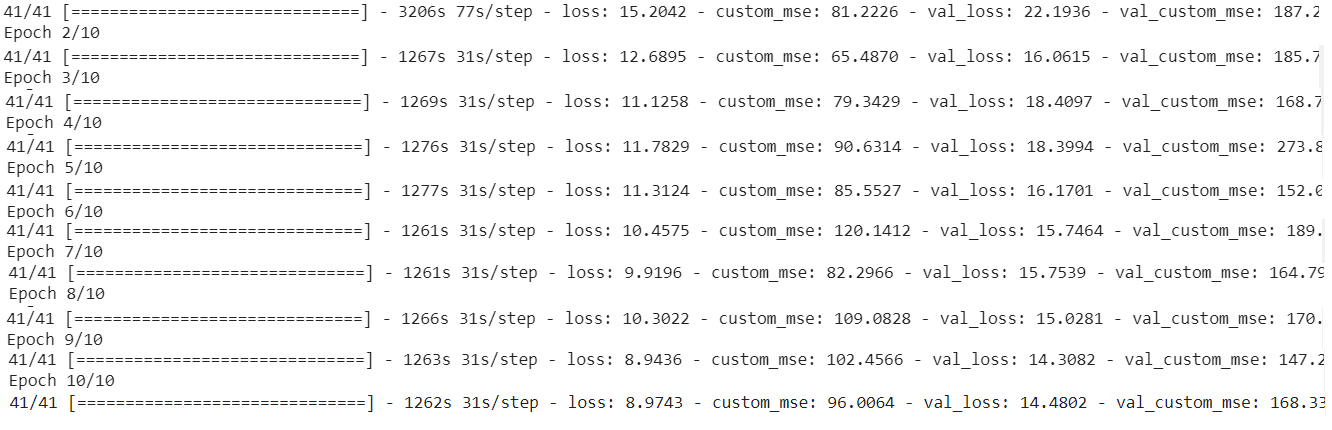

In [ ]:
vit_resnet_backbone_model.save("/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/save_model/vit_resnet_hungrian_bce_loss_2")

In [ ]:
vit_resnet_backbone_model.save("/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/save_model/vit_resnet_hungrian_bce_loss_3.h5")

# Test 

In [ ]:
num_of_image = '006484'
round = 'round1'

In [ ]:
def show_prediction(num_of_image,round):
    # RGB image
    test_predict_img_front_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/rgb_image/front_image/{round}/{round}_{num_of_image}.jpg'
    test_predict_img_left_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/rgb_image/left_image/{round}/{round}_{num_of_image}.jpg'
    test_predict_img_right_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/rgb_image/right_image/{round}/{round}_{num_of_image}.jpg'
    test_predict_img_back_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/rgb_image/back_image/{round}/{round}_{num_of_image}.jpg'

    test_predict_img_front = read_rgb_image(test_predict_img_path)
    test_predict_img_left = read_rgb_image(test_predict_img_left_path)
    test_predict_img_right = read_rgb_image(test_predict_img_right_path)
    test_predict_img_back = read_rgb_image(test_predict_img_back_path)

    # Depth image
    test_predict_img_front_depth_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/depth_image/front_image/{round}/{round}_{num_of_image}.png'
    test_predict_img_left_depth_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/depth_image/left_image/{round}/{round}_{num_of_image}.png'
    test_predict_img_righ_depth_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/depth_image/right_image/{round}/{round}_{num_of_image}.png'
    test_predict_img_back_depth_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/depth_image/back_image/{round}/{round}_{num_of_image}.png'

    test_predict_img_depth_front = read_depth_image(test_predict_img_front_depth_path)
    test_predict_img_depth_left = read_depth_image(test_predict_img_left_depth_path)
    test_predict_img_depth_right = read_depth_image(test_predict_img_righ_depth_path)
    test_predict_img_depth_back = read_depth_image(test_predict_img_back_depth_path)

    # Concatenate rgb and depth
    concatennate_rgb_depth_front = tf.concat([test_predict_img_front,test_predict_img_depth_front],axis=-1)
    concatennate_rgb_depth_right = tf.concat([test_predict_img_right,test_predict_img_depth_left],axis=-1)
    concatennate_rgb_depth_left = tf.concat([test_predict_img_left,test_predict_img_depth_left],axis=-1)
    concatennate_rgb_depth_back = tf.concat([test_predict_img_back,test_predict_img_depth_back],axis=-1)

    normalized_front = normalize_on_rgb_depth(concatennate_rgb_depth_front)
    normalized_left = normalize_on_rgb_depth(concatennate_rgb_depth_left)
    normalized_right = normalize_on_rgb_depth(concatennate_rgb_depth_right)
    normalized_back = normalize_on_rgb_depth(concatennate_rgb_depth_back)


    normalized_front_expand = tf.expand_dims(normalized_front,axis=0)
    normalized_left_expand = tf.expand_dims(normalized_left,axis=0)
    normalized_right_expand = tf.expand_dims(normalized_right,axis=0)
    normalized_back_expand = tf.expand_dims(normalized_back,axis=0)

    concat_all_sides = tf.concat([normalized_front_expand,normalized_left_expand,normalized_right_expand,normalized_back_expand],axis=0)    
    concat_all_sides = tf.expand_dims(concat_all_sides,axis = 0)

    # Run prediction
    prediction = vit_resnet_backbone_model.predict(concat_all_sides)
    plt.imshow(cv2.imread(test_predict_img_front_path))
    tf.print(prediction.reshape((7,4)))

In [ ]:
show_prediction(num_of_image,round)

RGB images

In [ ]:
test_predict_img_front_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/rgb_image/front_image/round3/round3_{num_of_image}.jpg'
test_predict_img_left_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/rgb_image/left_image/round3/round3_{num_of_image}.jpg'
test_predict_img_right_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/rgb_image/right_image/round3/round3_{num_of_image}.jpg'
test_predict_img_back_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/rgb_image/back_image/round3/round3_{num_of_image}.jpg'

test_predict_img_front = read_rgb_image(test_predict_img_path)
test_predict_img_left = read_rgb_image(test_predict_img_left_path)
test_predict_img_right = read_rgb_image(test_predict_img_right_path)
test_predict_img_back = read_rgb_image(test_predict_img_back_path)

Depth images

In [ ]:
test_predict_img_front_depth_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/depth_image/front_image/round3/round3_{num_of_image}.png'
test_predict_img_left_depth_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/depth_image/left_image/round3/round3_{num_of_image}.png'
test_predict_img_righ_depth_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/depth_image/right_image/round3/round3_{num_of_image}.png'
test_predict_img_back_depth_path = f'/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/carla_data_test/Town01/depth_image/back_image/round3/round3_{num_of_image}.png'

test_predict_img_depth_front = read_depth_image(test_predict_img_front_depth_path)
test_predict_img_depth_left = read_depth_image(test_predict_img_left_depth_path)
test_predict_img_depth_right = read_depth_image(test_predict_img_righ_depth_path)
test_predict_img_depth_back = read_depth_image(test_predict_img_back_depth_path)

Concatenate

In [ ]:
# Concatenate rgb and depth
concatennate_rgb_depth_front = tf.concat([test_predict_img_front,test_predict_img_depth_front],axis=-1)
concatennate_rgb_depth_right = tf.concat([test_predict_img_right,test_predict_img_depth_left],axis=-1)
concatennate_rgb_depth_left = tf.concat([test_predict_img_left,test_predict_img_depth_left],axis=-1)
concatennate_rgb_depth_back = tf.concat([test_predict_img_back,test_predict_img_depth_back],axis=-1)

normalized_front = normalize_on_rgb_depth(concatennate_rgb_depth_front)
normalized_left = normalize_on_rgb_depth(concatennate_rgb_depth_left)
normalized_right = normalize_on_rgb_depth(concatennate_rgb_depth_right)
normalized_back = normalize_on_rgb_depth(concatennate_rgb_depth_back)

In [ ]:
normalized_front_expand = tf.expand_dims(normalized_front,axis=0)
normalized_left_expand = tf.expand_dims(normalized_left,axis=0)
normalized_right_expand = tf.expand_dims(normalized_right,axis=0)
normalized_back_expand = tf.expand_dims(normalized_back,axis=0)

In [ ]:
normalized_back_expand.shape

In [ ]:
concat_all_sides = tf.concat([normalized_front_expand,normalized_left_expand,normalized_right_expand,normalized_back_expand],axis=0)

In [ ]:
concat_all_sides = tf.expand_dims(concat_all_sides,axis = 0)

In [ ]:
concat_all_sides.shape

In [ ]:
vit_resnet_backbone_model.predict(concat_all_sides)

# load model

In [ ]:
path_to_model = "/content/drive/Shareddrives/Behavior vehicles prediction_BME/carla_dataset/save_model/vit_resnet_hungrian_bce_loss_2"
custom_objects = {'Patches':Patches,'PatchEncoder': PatchEncoder, # Still have a problem here
                  'Hungarian_loss': hungarian_loss,
                  'custom_MSE': custom_MSE,
                  'hungarian_loss_fit':hungarian_loss_fit }
reconstructed_model = tf.keras.models.load_model(path_to_model,custom_objects=custom_objects)                                                                                                                                                     

In [ ]:
reconstructed_model.predict(concat_all_sides)